In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np

from tqdm import tqdm
from datetime import timedelta
from sklearn.decomposition import NMF

In [2]:
tqdm.pandas()

In [3]:
billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [4]:
plt.rcParams.update({'font.size': 15})

In [5]:
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]
billboard_hot_100["top_position"] = billboard_hot_100.groupby("artist_song")["position"].transform("min")

## Rank turnover

In [6]:
# number of songs ever seen until time t
def number_of_songs_seen(df, t):
    return len(df[df["first_day_of_the_week"] <= t]["artist_song"].unique())/100

100%|██████████| 3361/3361 [03:03<00:00, 18.27it/s]


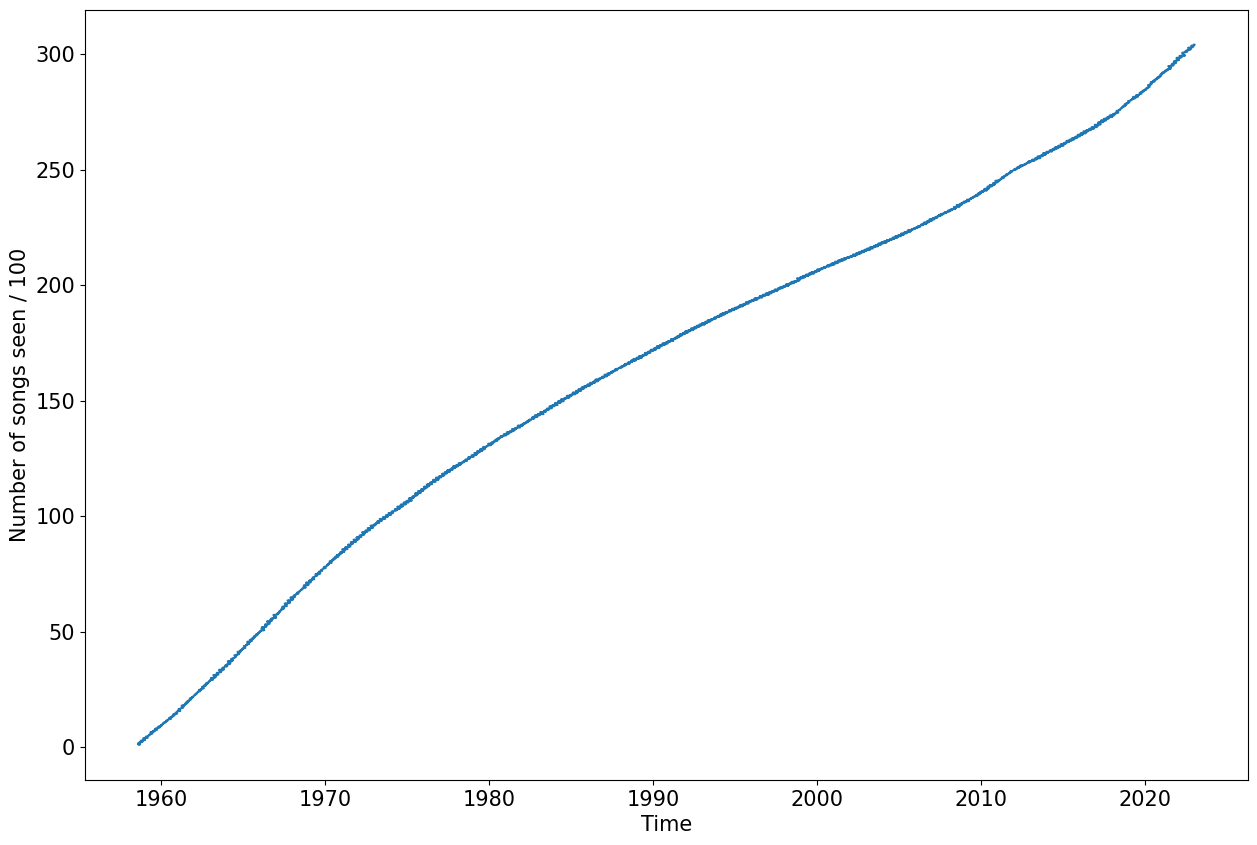

In [7]:
number_of_songs_ever_seen = []
for first_day_of_the_week in tqdm(billboard_hot_100["first_day_of_the_week"].sort_values().unique()):
    number_of_songs_ever_seen.append(number_of_songs_seen(billboard_hot_100, first_day_of_the_week))

plt.figure(figsize=(15, 10))
plt.plot(billboard_hot_100["first_day_of_the_week"].unique(), number_of_songs_ever_seen)
plt.xlabel("Time")
plt.ylabel("Number of songs seen / 100")
plt.show()

## Rank flux

In [8]:
songs_seen_t = {}
songs_seen_before_t = {}
for t in tqdm(billboard_hot_100["first_day_of_the_week"].unique()):
    songs_seen_t[t] = billboard_hot_100[billboard_hot_100["first_day_of_the_week"] <= t]["artist_song"].unique()
    songs_seen_before_t[t] = billboard_hot_100[billboard_hot_100["first_day_of_the_week"] < t]["artist_song"].unique()

100%|██████████| 3361/3361 [05:33<00:00, 10.07it/s]


In [9]:
# probabilities that song enter or leaves the chart at time t
def song_enter_leave_probabilities(df, t):
    songs_previous_week = df[df["first_day_of_the_week"] == (pd.to_datetime(t) - timedelta(weeks=1))]["artist_song"].unique()
    songs_now = df[df["first_day_of_the_week"] == t]["artist_song"].unique()
    songs_entered = list(set(songs_now) - set(songs_previous_week))
    songs_left = list(set(songs_previous_week) - set(songs_now))
    return (len(songs_entered) + len(songs_left))/200

100%|██████████| 3361/3361 [00:17<00:00, 196.44it/s]


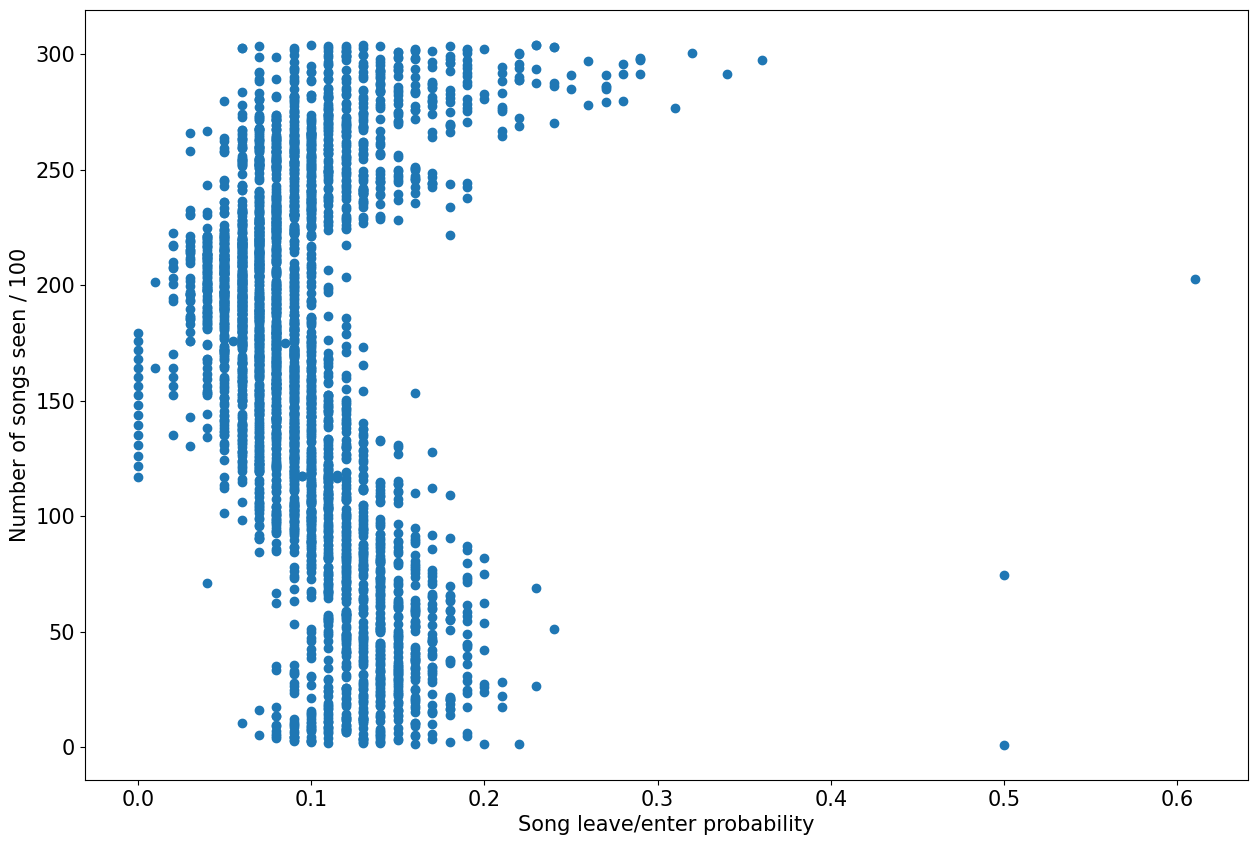

In [19]:
enter_leave_porbabilities = []
for first_day_of_the_week in tqdm(billboard_hot_100["first_day_of_the_week"].sort_values().unique()):
    enter_leave_porbabilities.append(song_enter_leave_probabilities(billboard_hot_100, first_day_of_the_week))

plt.figure(figsize=(15, 10))
plt.scatter(enter_leave_porbabilities, number_of_songs_ever_seen)
plt.xlabel("Song leave/enter probability")
plt.ylabel("Number of songs seen / 100")
# plt.yscale("log")
# plt.xscale("log")
plt.show()

In [11]:
np.corrcoef(number_of_songs_ever_seen, enter_leave_porbabilities)

array([[ 1.        , -0.20740298],
       [-0.20740298,  1.        ]])

## Rank change - Probability that element at position R changes between t-1 and time t 

In [12]:
billboard_hot_100["position_changed"] = billboard_hot_100["position"] != billboard_hot_100["last_week_position"]

In [13]:
# calculate probability that the songs at position R changed positionb between t-1 and t
def position_change_probability(df, R):
    df_position_r = df[df["position"] == R]
    
    number_of_songs_that_changed_position = len(df_position_r[df_position_r["position_changed"] == True])
    # songs_stayed = songs_stayed[:R]
    # songs_entered = songs_entered[:R]
    # songs_left = songs_left[:R]
    return number_of_songs_that_changed_position/df_position_r.shape[0]

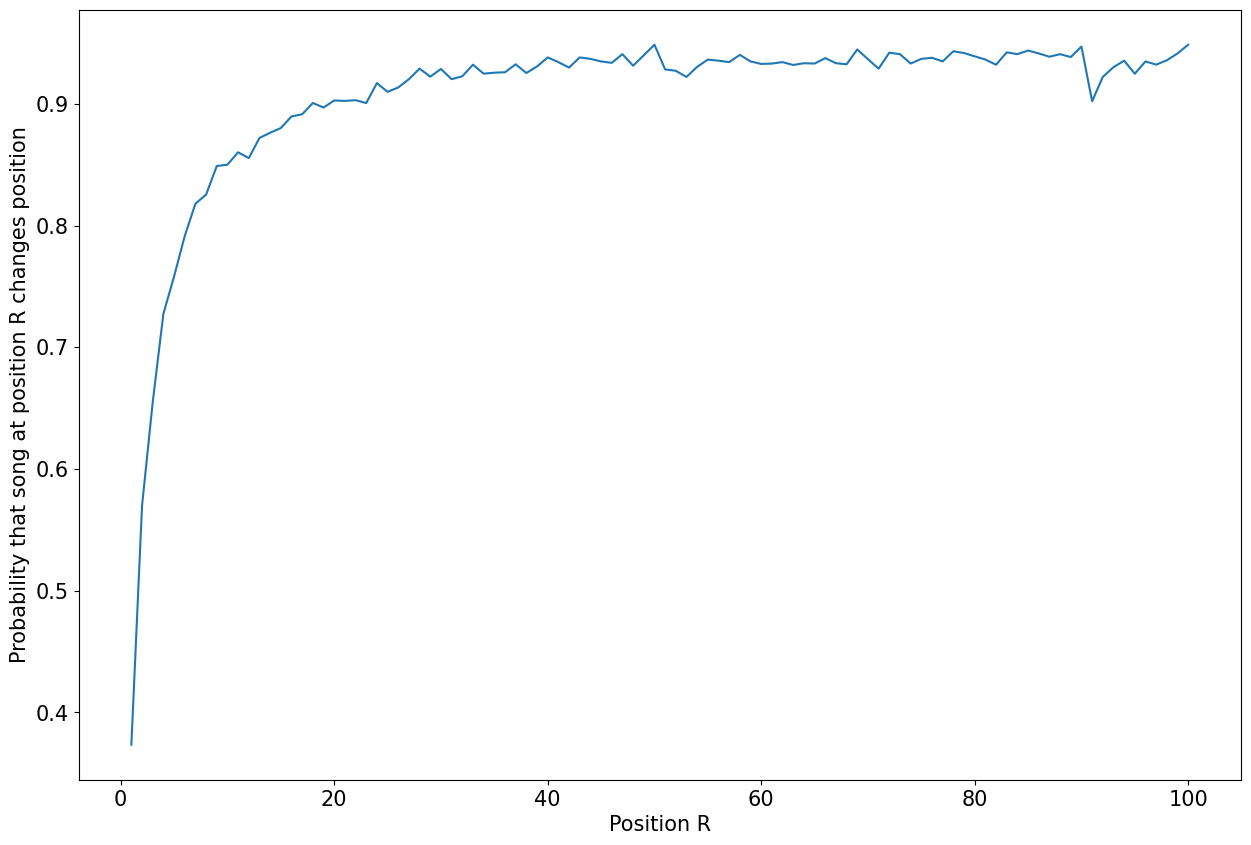

In [14]:
position_change_probabilities = []
for R in range(1, 101):
    position_change_probabilities.append(position_change_probability(billboard_hot_100, R))

plt.figure(figsize=(15, 10))
plt.plot(range(1, 101), position_change_probabilities)
plt.xlabel("Position R")
plt.ylabel("Probability that song at position R changes position")
plt.show()

## Trajectories for top 1, 10, 50, 100

In [15]:
top_1 = billboard_hot_100[(billboard_hot_100["year"] == 2013) & (billboard_hot_100["top_position"] == 1)]["artist_song"].iloc[0]
top_10 = billboard_hot_100[(billboard_hot_100["year"] == 2013) & (billboard_hot_100["top_position"] == 10)]["artist_song"].iloc[0]
top_50 = billboard_hot_100[(billboard_hot_100["year"] == 2013) & (billboard_hot_100["top_position"] == 50)]["artist_song"].iloc[0]
top_90 = billboard_hot_100[(billboard_hot_100["year"] == 2013) & (billboard_hot_100["top_position"] == 90)]["artist_song"].iloc[0]

In [16]:
print(top_1)
print(top_10)
print(top_50)
print(top_90)

Bruno Mars - Locked Out Of Heaven
Chris Brown - Don't Wake Me Up
T.I. Featuring Lil Wayne - Ball
DJ Drama Featuring Wale, Tyga & Roscoe Dash - So Many Girls


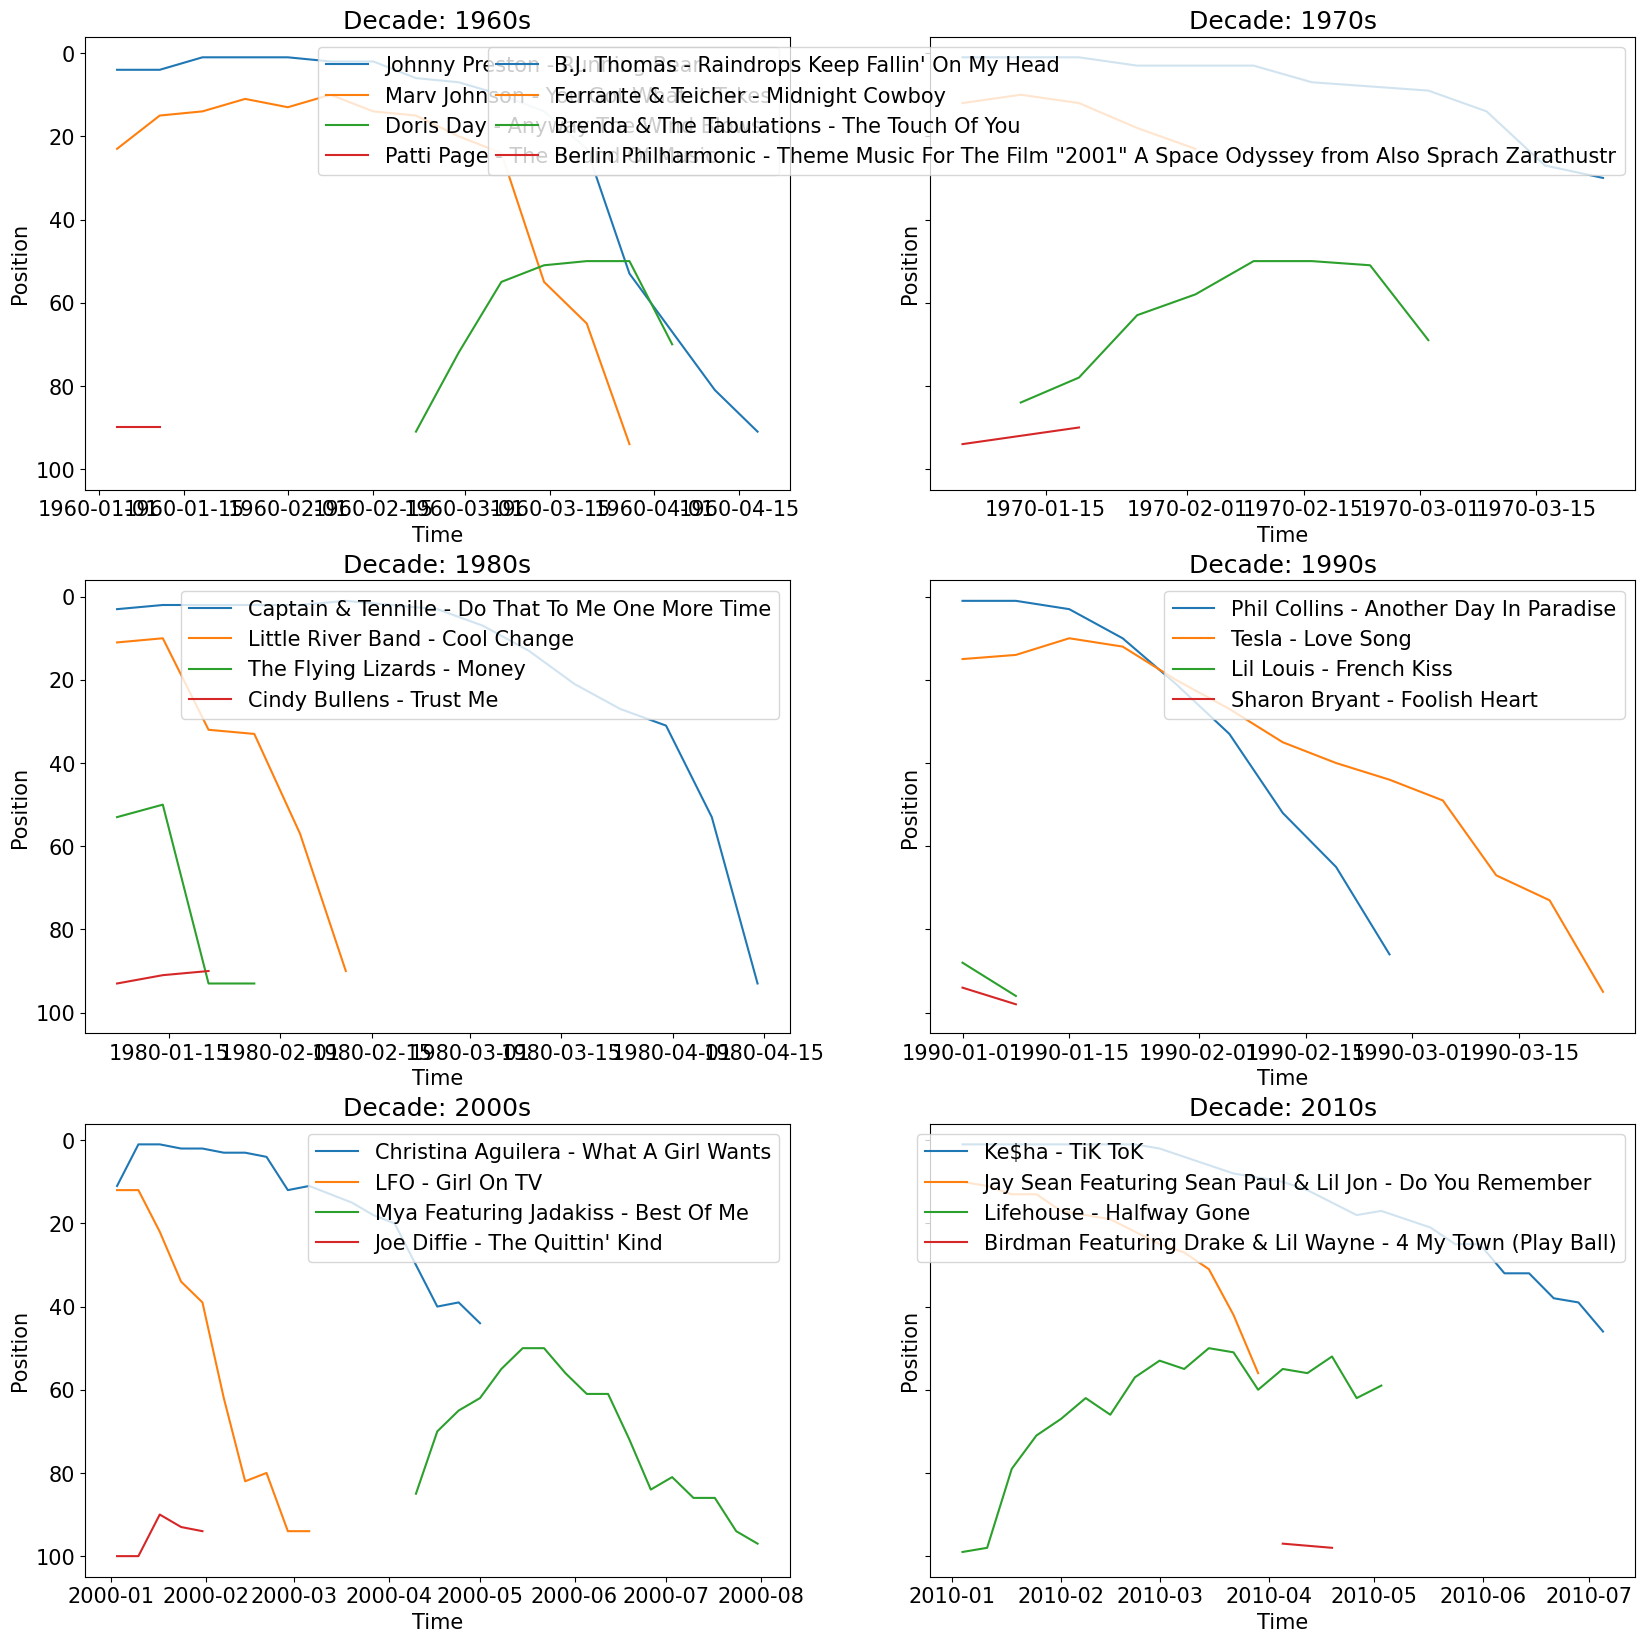

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=True)

row_i, col_i = 0, 0

for year in range(1960, 2020, 10):
    df_year = billboard_hot_100[(billboard_hot_100["year"] >= year) & (billboard_hot_100["year"] < year + 10)]
    
    top_1 = df_year[df_year["top_position"] == 1]["artist_song"].iloc[0]
    top_10 = df_year[df_year["top_position"] == 10]["artist_song"].iloc[0]
    top_50 = df_year[df_year["top_position"] == 50]["artist_song"].iloc[0]
    top_90 = df_year[df_year["top_position"] == 90]["artist_song"].iloc[0]
        
    df_top_1 = df_year[df_year["artist_song"] == top_1].sort_values(by="first_day_of_the_week")
    df_top_10 = df_year[df_year["artist_song"] == top_10].sort_values(by="first_day_of_the_week")
    df_top_50 = df_year[df_year["artist_song"] == top_50].sort_values(by="first_day_of_the_week")
    df_top_90 = df_year[df_year["artist_song"] == top_90].sort_values(by="first_day_of_the_week")
    
    axes[row_i, col_i].plot(df_top_1["first_day_of_the_week"], df_top_1["position"])
    axes[row_i, col_i].plot(df_top_10["first_day_of_the_week"], df_top_10["position"])
    axes[row_i, col_i].plot(df_top_50["first_day_of_the_week"], df_top_50["position"])
    axes[row_i, col_i].plot(df_top_90["first_day_of_the_week"], df_top_90["position"])
    axes[row_i, col_i].set_title(f"Decade: {year}s")
    axes[row_i, col_i].set_xlabel("Time")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].legend([top_1, top_10, top_50, top_90], loc="upper right")
    
    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

plt.gca().invert_yaxis()
plt.show()